In [ ]:
from spacepy import pycdf
cdf = pycdf.CDF('/work/AL1_ASW91_L2_BLK_20250630_UNP_9999_999999_V02.cdf')
print("Variables:", list(cdf.keys()))
cdf.close()


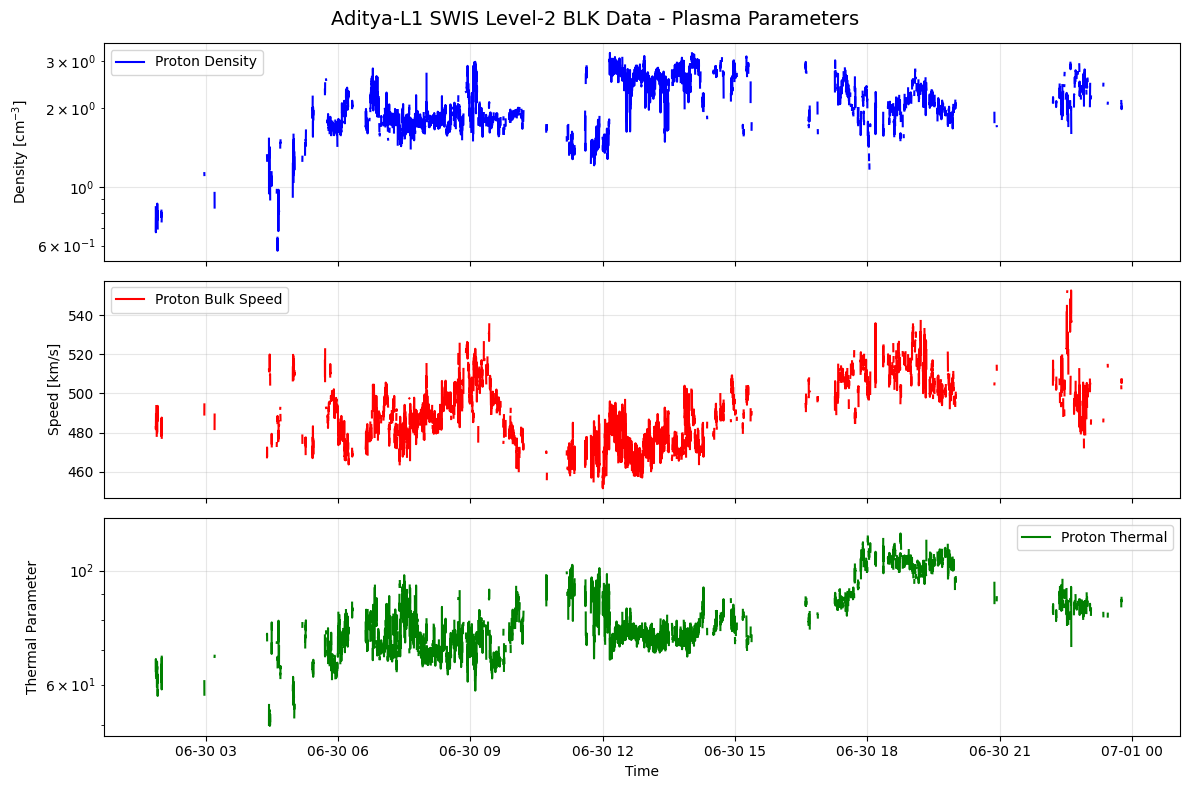

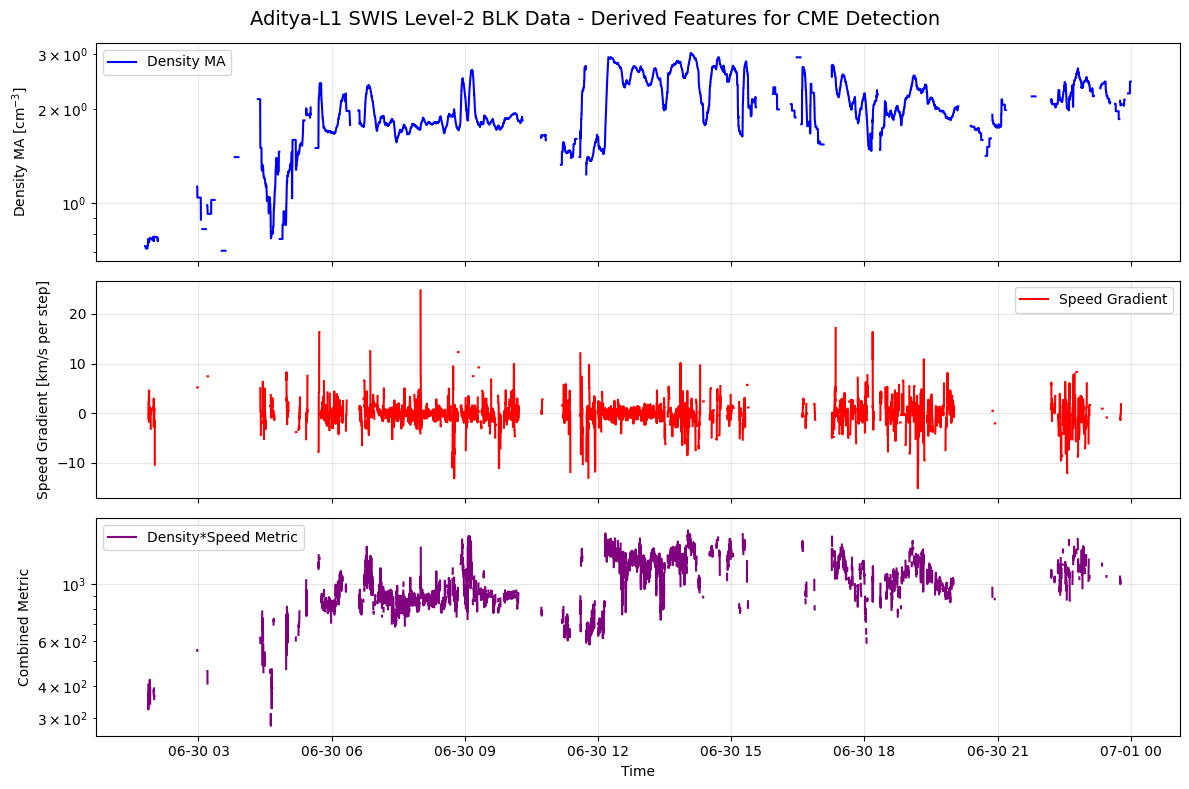

Data saved to 'aditya_l1_swis_data.csv'


In [ ]:
from spacepy import pycdf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

cdf_path = "/work/AL1_ASW91_L2_BLK_20250630_UNP_9999_999999_V02-20250703-172330.cdf"  # Adjust if filename or path differs
try:
    cdf = pycdf.CDF(cdf_path)
    print(f"Successfully opened CDF file: {cdf_path}")
except Exception as e:
    print(f"Error opening CDF file: {e}")
    exit(1)

epoch = cdf['epoch_for_cdf_mod'][...]
density = cdf['proton_density'][...] if 'proton_density' in cdf else np.full(len(epoch), np.nan)
speed = cdf['proton_bulk_speed'][...] if 'proton_bulk_speed' in cdf else np.full(len(epoch), np.nan)
temperature = cdf['proton_thermal'][...] if 'proton_thermal' in cdf else np.full(len(epoch), np.nan)

FILLVAL = -1e31
density = np.where(density == FILLVAL, np.nan, density)
speed = np.where(speed == FILLVAL, np.nan, speed)
temperature = np.where(temperature == FILLVAL, np.nan, temperature)

if isinstance(epoch[0], pd.Timestamp) or isinstance(epoch[0], np.datetime64) or hasattr(epoch[0], 'year'):
    time_dt = pd.to_datetime(epoch)
else:
    try:
        time_dt = pycdf.epoch_to_datetime(epoch)
    except Exception as e:
        print("SpacePy epoch_to_datetime failed, using manual conversion:", e)
        time_dt = pd.to_datetime(epoch - 62167219200000, unit='ms', origin='1970-01-01')

df = pd.DataFrame({
    'time': time_dt,
    'density_cm3': density,       # Assuming density is in cm⁻³; adjust if in m⁻³
    'speed_km_s': speed,          # Assuming speed is in km/s; adjust if in m/s
    'temperature': temperature    # Assuming thermal is temperature-related; adjust if in eV or other units
})

df['density_ma'] = df['density_cm3'].rolling(window=60, min_periods=1).mean()
df['speed_ma'] = df['speed_km_s'].rolling(window=60, min_periods=1).mean()
df['temp_ma'] = df['temperature'].rolling(window=60, min_periods=1).mean()

# Gradients (rate of change)
df['density_grad'] = df['density_cm3'].diff().rolling(window=10, min_periods=1).mean()
df['speed_grad'] = df['speed_km_s'].diff().rolling(window=10, min_periods=1).mean()

# Combined metric (example: density * speed)
df['combined_metric'] = df['density_cm3'] * df['speed_km_s']

# ---- Placeholder CME event timestamps from CACTUS database ----
# Replace these with actual CME event timestamps relevant to your data's date range
cme_events = [
    pd.to_datetime('2025-06-29 06:00:00'),  # Example CME event 1
    pd.to_datetime('2025-06-29 18:00:00')   # Example CME event 2
]

# ---- Plotting core parameters ----
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

axs[0].plot(df['time'], df['density_cm3'], 'b-', label='Proton Density')
axs[0].set_ylabel('Density [cm$^{-3}$]')
axs[0].grid(True, alpha=0.3)
axs[0].set_yscale('log')
axs[0].legend()

axs[1].plot(df['time'], df['speed_km_s'], 'r-', label='Proton Bulk Speed')
axs[1].set_ylabel('Speed [km/s]')
axs[1].grid(True, alpha=0.3)
axs[1].legend()

axs[2].plot(df['time'], df['temperature'], 'g-', label='Proton Thermal')
axs[2].set_ylabel('Thermal Parameter')
axs[2].grid(True, alpha=0.3)
axs[2].set_yscale('log')
axs[2].set_xlabel('Time')
axs[2].legend()

plt.suptitle('Aditya-L1 SWIS Level-2 BLK Data - Plasma Parameters', fontsize=14)
plt.tight_layout()
plt.savefig('aditya_l1_swis_parameters.png', dpi=300)
plt.show()

fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

axs[0].plot(df['time'], df['density_ma'], 'b-', label='Density MA')
axs[0].set_ylabel('Density MA [cm$^{-3}$]')
axs[0].grid(True, alpha=0.3)
axs[0].set_yscale('log')
axs[0].legend()
for cme_time in cme_events:
    axs[0].axvline(x=cme_time, color='gray', linestyle='--', alpha=0.5, label='CME Event' if cme_time == cme_events[0] else "")

axs[1].plot(df['time'], df['speed_grad'], 'r-', label='Speed Gradient')
axs[1].set_ylabel('Speed Gradient [km/s per step]')
axs[1].grid(True, alpha=0.3)
axs[1].legend()
for cme_time in cme_events:
    axs[1].axvline(x=cme_time, color='gray', linestyle='--', alpha=0.5, label='CME Event' if cme_time == cme_events[0] else "")

axs[2].plot(df['time'], df['combined_metric'], 'purple', label='Density*Speed Metric')
axs[2].set_ylabel('Combined Metric')
axs[2].grid(True, alpha=0.3)
axs[2].set_yscale('log')
axs[2].set_xlabel('Time')
axs[2].legend()
for cme_time in cme_events:
    axs[2].axvline(x=cme_time, color='gray', linestyle='--', alpha=0.5, label='CME Event' if cme_time == cme_events[0] else "")

plt.suptitle('Aditya-L1 SWIS Level-2 BLK Data - Derived Features for CME Detection', fontsize=14)
plt.tight_layout()
plt.savefig('aditya_l1_swis_derived_features.png', dpi=300)
plt.show()

df.to_csv('aditya_l1_swis_data.csv', index=False)
print("Data saved to 'aditya_l1_swis_data.csv'")
cdf.close()


In [46]:
from spacepy import pycdf
import numpy as np
import pandas as pd

cdf_path = "/work/AL1_ASW91_L2_BLK_20250630_UNP_9999_999999_V02.cdf"
cdf = pycdf.CDF(cdf_path)

# Extract variables
epoch = cdf['epoch_for_cdf_mod'][...]
density = cdf['proton_density'][...]
speed = cdf['proton_bulk_speed'][...]
temperature = cdf['proton_thermal'][...]

# ---- Mask fill values ----
FILLVAL = -1e31
density = np.where(density == FILLVAL, np.nan, density)
speed = np.where(speed == FILLVAL, np.nan, speed)
temperature = np.where(temperature == FILLVAL, np.nan, temperature)

# ---- Convert epoch to datetime ----
if isinstance(epoch[0], pd.Timestamp) or isinstance(epoch[0], np.datetime64) or hasattr(epoch[0], 'year'):
    time_dt = pd.to_datetime(epoch)
else:
    try:
        time_dt = pycdf.epoch_to_datetime(epoch)
    except Exception as e:
        print("SpacePy epoch_to_datetime failed, using manual conversion:", e)
        time_dt = pd.to_datetime(epoch - 62167219200000, unit='ms', origin='1970-01-01')

# ---- Create DataFrame ----
df = pd.DataFrame({
    'time': time_dt,
    'density_cm3': density,
    'speed_km_s': speed,
    'temperature': temperature
})

# ---- Compute derived features ----
df['density_ma'] = df['density_cm3'].rolling(window=60, min_periods=1).mean()
df['speed_ma'] = df['speed_km_s'].rolling(window=60, min_periods=1).mean()
df['temp_ma'] = df['temperature'].rolling(window=60, min_periods=1).mean()
df['density_grad'] = df['density_cm3'].diff().rolling(window=10, min_periods=1).mean()
df['speed_grad'] = df['speed_km_s'].diff().rolling(window=10, min_periods=1).mean()
df['combined_metric'] = df['density_cm3'] * df['speed_km_s']

df.to_csv('aditya_l1_swis_data.csv', index=False)
print("Data saved to 'aditya_l1_swis_data.csv'")

cdf.close()


Data saved to 'aditya_l1_swis_data.csv'


# new 

Successfully opened BLK CDF file: /work/AL1_ASW91_L2_BLK_20250630_UNP_9999_999999_V02.cdf
CME Detection Thresholds (based on quiet period analysis):
- Density Threshold: 2.94 cm⁻³
- Speed Threshold: 616.74 km/s
- Speed Gradient Threshold: 12.67 km/s per step
- Combined Metric Threshold: 1421.02

Potential CME Events Detected (by hour):
date_hour
2025-06-30 09     4
2025-06-30 12    64
2025-06-30 13     2
2025-06-30 14    54
2025-06-30 15     3
2025-06-30 16     1
2025-06-30 17     2
2025-06-30 22     2
dtype: int64
Successfully opened MAG NetCDF file: /work/L2_AL1_MAG_20250630_V00.nc
- B_total Threshold: 13.21 nT


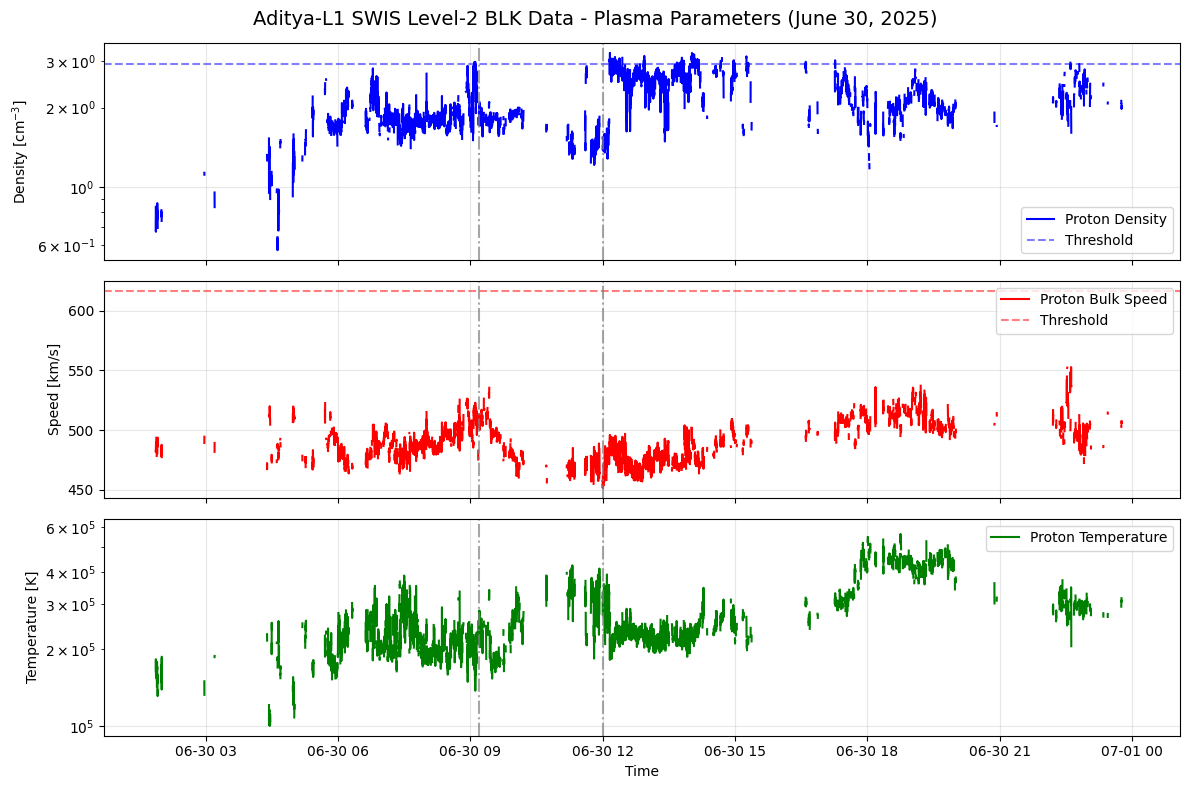

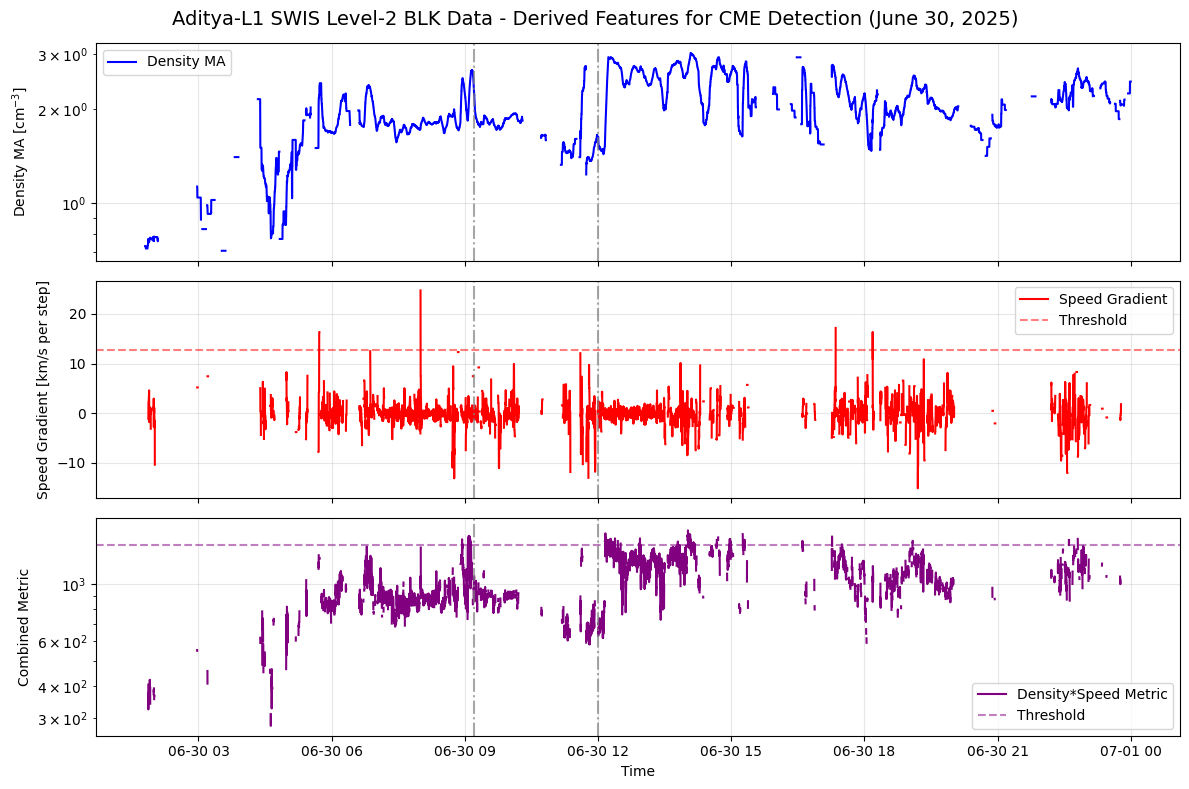

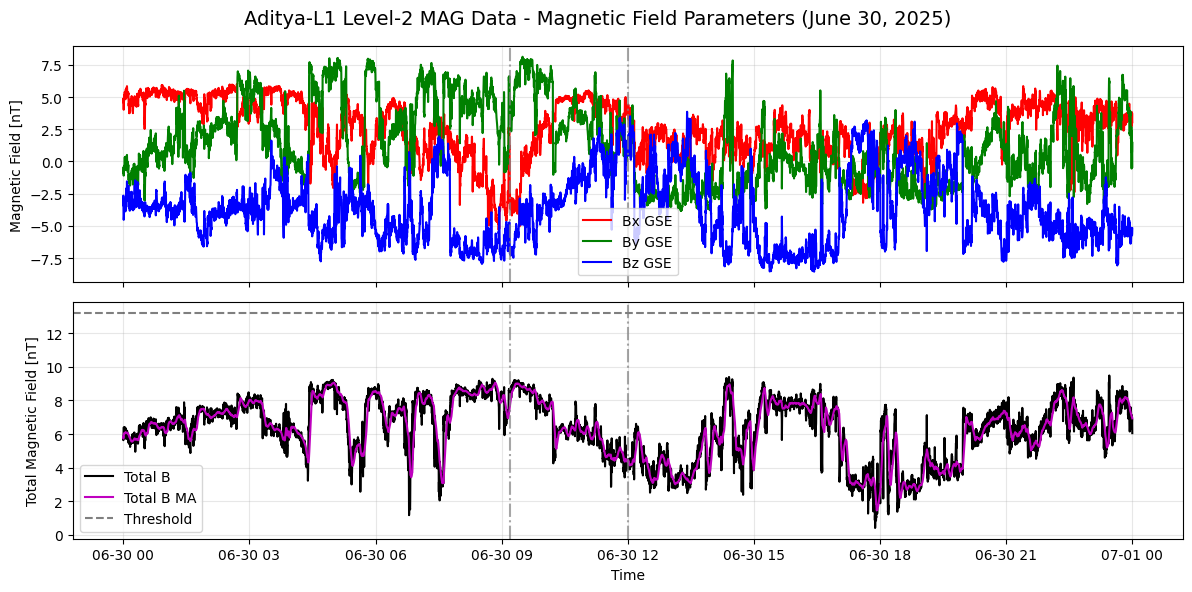

Data saved to 'aditya_l1_swis_data_june30.csv' and 'aditya_l1_mag_data_june30.csv'


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from spacepy import pycdf
from netCDF4 import Dataset
from datetime import datetime

# ---- File paths for BLK and MAG data (adjust as needed) ----
blk_path = "/work/AL1_ASW91_L2_BLK_20250630_UNP_9999_999999_V02.cdf"
mag_path = "/work/L2_AL1_MAG_20250630_V00.nc"

# ---- CACTUS CME timestamps for June 30, 2025 ----
cme_events_cactus = [
    pd.to_datetime('2025-06-30 09:12:00'),
    pd.to_datetime('2025-06-30 12:00:00')
]

# ---- Load BLK CDF file for plasma parameters ----
try:
    cdf = pycdf.CDF(blk_path)
    print(f"Successfully opened BLK CDF file: {blk_path}")
except Exception as e:
    print(f"Error opening BLK CDF file: {e}")
    exit(1)

# ---- Extract variables from BLK file ----
epoch = cdf['epoch_for_cdf_mod'][...]
proton_density = cdf['proton_density'][...]
proton_bulk_speed = cdf['proton_bulk_speed'][...]
proton_thermal = cdf['proton_thermal'][...]

# ---- Mask fill values ----
FILLVAL = -1e31
proton_density = np.where(proton_density == FILLVAL, np.nan, proton_density)
proton_bulk_speed = np.where(proton_bulk_speed == FILLVAL, np.nan, proton_bulk_speed)
proton_thermal = np.where(proton_thermal == FILLVAL, np.nan, proton_thermal)

# ---- Robust conversion of CDF epoch to datetime ----
if isinstance(epoch[0], pd.Timestamp) or isinstance(epoch[0], np.datetime64) or hasattr(epoch[0], 'year'):
    time_dt = pd.to_datetime(epoch)
else:
    try:
        time_dt = pycdf.epoch_to_datetime(epoch)
    except Exception as e:
        print("SpacePy epoch_to_datetime failed, using manual conversion:", e)
        time_dt = pd.to_datetime(epoch - 62167219200000, unit='ms', origin='1970-01-01')

# ---- Convert thermal speed (km/s) to temperature (K) ----
m_p = 1.6726219e-27  # Proton mass (kg)
kB = 1.380649e-23    # Boltzmann constant (J/K)
proton_temp_K = (m_p * (proton_thermal * 1e3)**2) / (3 * kB)  # Convert km/s to m/s

# ---- Create DataFrame with extracted BLK parameters ----
df_blk = pd.DataFrame({
    'time': time_dt,
    'density_cm3': proton_density,
    'speed_km_s': proton_bulk_speed,
    'thermal_km_s': proton_thermal,
    'temperature_K': proton_temp_K
})

# ---- Compute derived features for CME detection from BLK data ----
df_blk['density_ma'] = df_blk['density_cm3'].rolling(window=60, min_periods=1).mean()
df_blk['speed_ma'] = df_blk['speed_km_s'].rolling(window=60, min_periods=1).mean()
df_blk['temp_ma'] = df_blk['temperature_K'].rolling(window=60, min_periods=1).mean()
df_blk['density_grad'] = df_blk['density_cm3'].diff().rolling(window=10, min_periods=1).mean()
df_blk['speed_grad'] = df_blk['speed_km_s'].diff().rolling(window=10, min_periods=1).mean()
df_blk['combined_metric'] = df_blk['density_cm3'] * df_blk['speed_km_s']

# ---- Determine statistical thresholds for CME detection ----
# Using first 25% of data as a quiet period baseline (adjust based on CACTUS data or known quiet times)
quiet_period = int(len(df_blk) * 0.25)
density_threshold = df_blk['density_cm3'][:quiet_period].quantile(0.95) * 1.5
speed_threshold = df_blk['speed_km_s'][:quiet_period].quantile(0.95) * 1.2
speed_grad_threshold = df_blk['speed_grad'][quiet_period//2:quiet_period].quantile(0.95) * 2  # Avoid initial NaNs
combined_metric_threshold = df_blk['combined_metric'][quiet_period//2:quiet_period].quantile(0.95) * 1.5

print(f"CME Detection Thresholds (based on quiet period analysis):")
print(f"- Density Threshold: {density_threshold:.2f} cm⁻³")
print(f"- Speed Threshold: {speed_threshold:.2f} km/s")
print(f"- Speed Gradient Threshold: {speed_grad_threshold:.2f} km/s per step")
print(f"- Combined Metric Threshold: {combined_metric_threshold:.2f}")

# ---- Apply thresholds to flag potential CME events ----
df_blk['cme_flag_density'] = df_blk['density_cm3'] > density_threshold
df_blk['cme_flag_speed'] = df_blk['speed_km_s'] > speed_threshold
df_blk['cme_flag_speed_grad'] = df_blk['speed_grad'] > speed_grad_threshold
df_blk['cme_flag_combined'] = df_blk['combined_metric'] > combined_metric_threshold

# Combined flag: At least two criteria must be met for a CME flag
df_blk['cme_flag'] = (df_blk[['cme_flag_density', 'cme_flag_speed', 'cme_flag_speed_grad', 'cme_flag_combined']].sum(axis=1) >= 2)

# Summarize detected events (group by hour to avoid too many individual flags)
df_blk['date_hour'] = df_blk['time'].dt.strftime('%Y-%m-%d %H')
cme_events_detected = df_blk[df_blk['cme_flag']].groupby('date_hour').size()
print("\nPotential CME Events Detected (by hour):")
print(cme_events_detected)

# ---- Load MAG NetCDF file for magnetic field data ----
try:
    nc = Dataset(mag_path, mode='r')
    print(f"Successfully opened MAG NetCDF file: {mag_path}")
    # Extract time and magnetic field components
    mag_time = nc.variables['time'][:]
    bx_gse = nc.variables['Bx_gse'][:]
    by_gse = nc.variables['By_gse'][:]
    bz_gse = nc.variables['Bz_gse'][:]
    # Convert time (assuming it's in a format like seconds since a reference date; adjust based on 'units' attribute)
    time_units = nc.variables['time'].units if 'units' in nc.variables['time'].ncattrs() else "seconds since 1970-01-01"
    if "since" in time_units:
        ref_date = pd.to_datetime(time_units.split("since")[1].strip())
        mag_time_dt = ref_date + pd.to_timedelta(mag_time, unit='s')
    else:
        mag_time_dt = pd.to_datetime(mag_time, unit='s', origin='1970-01-01')  # Fallback assumption
    nc.close()
    # Mask fill values for MAG data (assuming similar fill value or extreme values)
    bx_gse = np.where((bx_gse == FILLVAL) | (bx_gse < -1e30) | (bx_gse > 1e30), np.nan, bx_gse)
    by_gse = np.where((by_gse == FILLVAL) | (by_gse < -1e30) | (by_gse > 1e30), np.nan, by_gse)
    bz_gse = np.where((bz_gse == FILLVAL) | (bz_gse < -1e30) | (bz_gse > 1e30), np.nan, bz_gse)
    b_total = np.sqrt(bx_gse**2 + by_gse**2 + bz_gse**2)
    # Create DataFrame for magnetic data
    df_mag = pd.DataFrame({
        'time': mag_time_dt,
        'Bx_gse': bx_gse,
        'By_gse': by_gse,
        'Bz_gse': bz_gse,
        'B_total': b_total
    })
    # Compute derived features for MAG data
    df_mag['B_total_ma'] = df_mag['B_total'].rolling(window=30, min_periods=1).mean()
    df_mag['B_total_grad'] = df_mag['B_total'].diff().rolling(window=5, min_periods=1).mean()
    # Determine threshold for B_total (e.g., for intensity assessment)
    b_total_threshold = df_mag['B_total'][:int(len(df_mag)*0.25)].quantile(0.95) * 1.5
    print(f"- B_total Threshold: {b_total_threshold:.2f} nT")
except Exception as e:
    print(f"Error opening MAG NetCDF file: {e}")
    print("Continuing with particle data only.")
    df_mag = pd.DataFrame(columns=['time', 'Bx_gse', 'By_gse', 'Bz_gse', 'B_total'])

# ---- Plotting core parameters with thresholds and CACTUS events (BLK data) ----
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
axs[0].plot(df_blk['time'], df_blk['density_cm3'], 'b-', label='Proton Density')
axs[0].axhline(y=density_threshold, color='b', linestyle='--', alpha=0.5, label='Threshold')
axs[0].set_ylabel('Density [cm$^{-3}$]')
axs[0].grid(True, alpha=0.3)
axs[0].set_yscale('log')
axs[0].legend()
for i, cme_time in enumerate(cme_events_cactus):
    if df_blk['time'].min() <= cme_time <= df_blk['time'].max():
        axs[0].axvline(x=cme_time, color='gray', linestyle='-.', alpha=0.7, label='CACTUS CME' if i == 0 else "")

axs[1].plot(df_blk['time'], df_blk['speed_km_s'], 'r-', label='Proton Bulk Speed')
axs[1].axhline(y=speed_threshold, color='r', linestyle='--', alpha=0.5, label='Threshold')
axs[1].set_ylabel('Speed [km/s]')
axs[1].grid(True, alpha=0.3)
axs[1].legend()
for i, cme_time in enumerate(cme_events_cactus):
    if df_blk['time'].min() <= cme_time <= df_blk['time'].max():
        axs[1].axvline(x=cme_time, color='gray', linestyle='-.', alpha=0.7, label='CACTUS CME' if i == 0 else "")

axs[2].plot(df_blk['time'], df_blk['temperature_K'], 'g-', label='Proton Temperature')
axs[2].set_ylabel('Temperature [K]')
axs[2].grid(True, alpha=0.3)
axs[2].set_yscale('log')
axs[2].set_xlabel('Time')
axs[2].legend()
for i, cme_time in enumerate(cme_events_cactus):
    if df_blk['time'].min() <= cme_time <= df_blk['time'].max():
        axs[2].axvline(x=cme_time, color='gray', linestyle='-.', alpha=0.7, label='CACTUS CME' if i == 0 else "")

plt.suptitle('Aditya-L1 SWIS Level-2 BLK Data - Plasma Parameters (June 30, 2025)', fontsize=14)
plt.tight_layout()
plt.savefig('aditya_l1_swis_parameters_june30.png', dpi=300)
plt.show()

# ---- Plotting derived features for CME detection with thresholds and CACTUS events (BLK data) ----
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
axs[0].plot(df_blk['time'], df_blk['density_ma'], 'b-', label='Density MA')
axs[0].set_ylabel('Density MA [cm$^{-3}$]')
axs[0].grid(True, alpha=0.3)
axs[0].set_yscale('log')
axs[0].legend()
for i, cme_time in enumerate(cme_events_cactus):
    if df_blk['time'].min() <= cme_time <= df_blk['time'].max():
        axs[0].axvline(x=cme_time, color='gray', linestyle='-.', alpha=0.7, label='CACTUS CME' if i == 0 else "")

axs[1].plot(df_blk['time'], df_blk['speed_grad'], 'r-', label='Speed Gradient')
axs[1].axhline(y=speed_grad_threshold, color='r', linestyle='--', alpha=0.5, label='Threshold')
axs[1].set_ylabel('Speed Gradient [km/s per step]')
axs[1].grid(True, alpha=0.3)
axs[1].legend()
for i, cme_time in enumerate(cme_events_cactus):
    if df_blk['time'].min() <= cme_time <= df_blk['time'].max():
        axs[1].axvline(x=cme_time, color='gray', linestyle='-.', alpha=0.7, label='CACTUS CME' if i == 0 else "")

axs[2].plot(df_blk['time'], df_blk['combined_metric'], 'purple', label='Density*Speed Metric')
axs[2].axhline(y=combined_metric_threshold, color='purple', linestyle='--', alpha=0.5, label='Threshold')
axs[2].set_ylabel('Combined Metric')
axs[2].grid(True, alpha=0.3)
axs[2].set_yscale('log')
axs[2].set_xlabel('Time')
axs[2].legend()
for i, cme_time in enumerate(cme_events_cactus):
    if df_blk['time'].min() <= cme_time <= df_blk['time'].max():
        axs[2].axvline(x=cme_time, color='gray', linestyle='-.', alpha=0.7, label='CACTUS CME' if i == 0 else "")

plt.suptitle('Aditya-L1 SWIS Level-2 BLK Data - Derived Features for CME Detection (June 30, 2025)', fontsize=14)
plt.tight_layout()
plt.savefig('aditya_l1_swis_derived_features_june30.png', dpi=300)
plt.show()

# ---- Plotting magnetic field parameters with CACTUS events (MAG data, if available) ----
if not df_mag.empty:
    fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    axs[0].plot(df_mag['time'], df_mag['Bx_gse'], 'r-', label='Bx GSE')
    axs[0].plot(df_mag['time'], df_mag['By_gse'], 'g-', label='By GSE')
    axs[0].plot(df_mag['time'], df_mag['Bz_gse'], 'b-', label='Bz GSE')
    axs[0].set_ylabel('Magnetic Field [nT]')
    axs[0].grid(True, alpha=0.3)
    axs[0].legend()
    for i, cme_time in enumerate(cme_events_cactus):
        if df_mag['time'].min() <= cme_time <= df_mag['time'].max():
            axs[0].axvline(x=cme_time, color='gray', linestyle='-.', alpha=0.7, label='CACTUS CME' if i == 0 else "")

    axs[1].plot(df_mag['time'], df_mag['B_total'], 'k-', label='Total B')
    axs[1].plot(df_mag['time'], df_mag['B_total_ma'], 'm-', label='Total B MA')
    axs[1].axhline(y=b_total_threshold, color='k', linestyle='--', alpha=0.5, label='Threshold')
    axs[1].set_ylabel('Total Magnetic Field [nT]')
    axs[1].grid(True, alpha=0.3)
    axs[1].set_xlabel('Time')
    axs[1].legend()
    for i, cme_time in enumerate(cme_events_cactus):
        if df_mag['time'].min() <= cme_time <= df_mag['time'].max():
            axs[1].axvline(x=cme_time, color='gray', linestyle='-.', alpha=0.7, label='CACTUS CME' if i == 0 else "")

    plt.suptitle('Aditya-L1 Level-2 MAG Data - Magnetic Field Parameters (June 30, 2025)', fontsize=14)
    plt.tight_layout()
    plt.savefig('aditya_l1_mag_parameters_june30.png', dpi=300)
    plt.show()
else:
    print("Magnetic field data not plotted due to earlier error or unavailability.")

# ---- Save DataFrames for further analysis ----
df_blk.to_csv('aditya_l1_swis_data_june30.csv', index=False)
if not df_mag.empty:
    df_mag.to_csv('aditya_l1_mag_data_june30.csv', index=False)
    print("Data saved to 'aditya_l1_swis_data_june30.csv' and 'aditya_l1_mag_data_june30.csv'")
else:
    print("Data saved to 'aditya_l1_swis_data_june30.csv'")

# ---- Close CDF file ----
cdf.close()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e60a24d0-64ab-4d4c-924c-56a613793cdc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>